# <center>Customer Churn - Logistic Regression<center>

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import scipy.optimize as opt
from sklearn import preprocessing
import seaborn as sns

In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
sns.set_style(style='whitegrid')

<h2>About the Data</h2>

We will use a telecommunications dataset for predicting customer churn. This is a historical customer dataset where each row represents one customer. The data is relatively easy to understand, and you may uncover insights you can use immediately. Typically it is less expensive to keep customers than acquire new ones, so the focus of this analysis is to predict the customers who will stay with the company. 


This data set provides information to help you predict what behavior will help you to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.



The dataset includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they had been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

In [2]:
!wget -O ChurnData.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/ChurnData.csv

--2020-01-18 21:04:31--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/ChurnData.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36144 (35K) [text/csv]
Saving to: 'ChurnData.csv'

ChurnData.csv       100%[===================>]  35.30K  --.-KB/s    in 0.1s    

2020-01-18 21:04:31 (369 KB/s) - 'ChurnData.csv' saved [36144/36144]



In [3]:
df = pd.read_csv('ChurnData.csv')
df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


# Missing Values

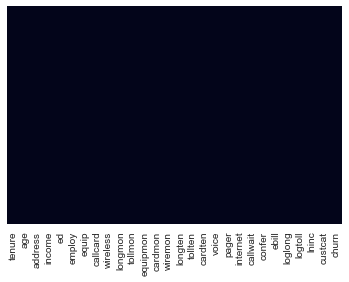

In [5]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False)

This data has no missing values, so we proceed on with Data pre-processing. 

# Data pre-processing and Analysis

### Correlation of the features

In [6]:
df.corr()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,tollmon,equipmon,cardmon,wiremon,longten,tollten,cardten,voice,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
tenure,1.000000,0.431802,0.456328,0.109383,-0.070503,0.445755,-0.117102,0.426530,-0.070590,0.763134,0.100214,-0.043274,0.489857,0.043067,0.796355,0.398869,0.676920,-0.050686,0.018791,-0.164921,-0.009747,0.080650,-0.099128,0.864388,0.310045,0.246353,0.134237,-0.376860
age,0.431802,1.000000,0.746566,0.211275,-0.071509,0.622553,-0.071357,0.170404,-0.065527,0.373547,0.053595,-0.030402,0.203202,-0.003685,0.393370,0.187221,0.336903,0.019555,0.006803,-0.078395,0.020002,0.030625,-0.048279,0.379413,0.093600,0.313359,0.041055,-0.287697
address,0.456328,0.746566,1.000000,0.132807,-0.145550,0.520926,-0.148977,0.209204,-0.146478,0.421782,-0.015564,-0.125212,0.297395,-0.113143,0.447256,0.129141,0.406964,-0.069627,-0.105812,-0.191058,-0.019967,-0.030494,-0.172171,0.409357,0.018386,0.212929,-0.016841,-0.260659
income,0.109383,0.211275,0.132807,1.000000,0.141241,0.345161,-0.010741,-0.019969,-0.029635,0.041808,-0.003701,0.000275,-0.013513,-0.027998,0.048374,-0.000262,0.019358,0.085525,0.056977,0.102809,0.081133,-0.031556,-0.041392,0.065595,-0.156498,0.680313,0.030725,-0.090790
ed,-0.070503,-0.071509,-0.145550,0.141241,1.000000,-0.213886,0.488041,-0.071178,0.267670,-0.072735,-0.000712,0.492999,-0.070990,0.288571,-0.083032,-0.016257,-0.069499,0.233628,0.258698,0.552996,-0.016247,-0.132215,0.427315,-0.054581,-0.007227,0.206718,0.013127,0.216112
employ,0.445755,0.622553,0.520926,0.345161,-0.213886,1.000000,-0.174470,0.266612,-0.101187,0.363386,0.117962,-0.141651,0.219413,-0.045539,0.385254,0.240498,0.309183,-0.035922,0.038381,-0.250044,0.119708,0.173247,-0.151965,0.377186,0.068718,0.540052,0.131292,-0.337969
equip,-0.117102,-0.071357,-0.148977,-0.010741,0.488041,-0.174470,1.000000,-0.087051,0.386735,-0.097618,-0.090516,0.941065,-0.056590,0.367579,-0.098271,-0.097151,-0.053837,0.264481,0.308633,0.623509,-0.034021,-0.103499,0.603133,-0.113065,-0.027882,0.083494,0.174955,0.275284
callcard,0.426530,0.170404,0.209204,-0.019969,-0.071178,0.266612,-0.087051,1.000000,0.220118,0.322514,0.352994,0.026955,0.629955,0.259638,0.342553,0.292555,0.448182,0.226109,0.251069,-0.067146,0.370878,0.311056,-0.045058,0.351030,0.080060,0.156920,0.407553,-0.311451
wireless,-0.070590,-0.065527,-0.146478,-0.029635,0.267670,-0.101187,0.386735,0.220118,1.000000,-0.073043,0.462751,0.527573,0.195387,0.885879,-0.088461,0.328256,0.047773,0.649721,0.667535,0.343631,0.389670,0.382925,0.321433,-0.042637,0.178317,0.033558,0.598156,0.174356
longmon,0.763134,0.373547,0.421782,0.041808,-0.072735,0.363386,-0.097618,0.322514,-0.073043,1.000000,0.083771,-0.070876,0.493439,-0.020392,0.984808,0.338036,0.673179,-0.080503,-0.001372,-0.223929,0.032913,0.060614,-0.124605,0.901631,0.247302,0.122550,0.072519,-0.292026


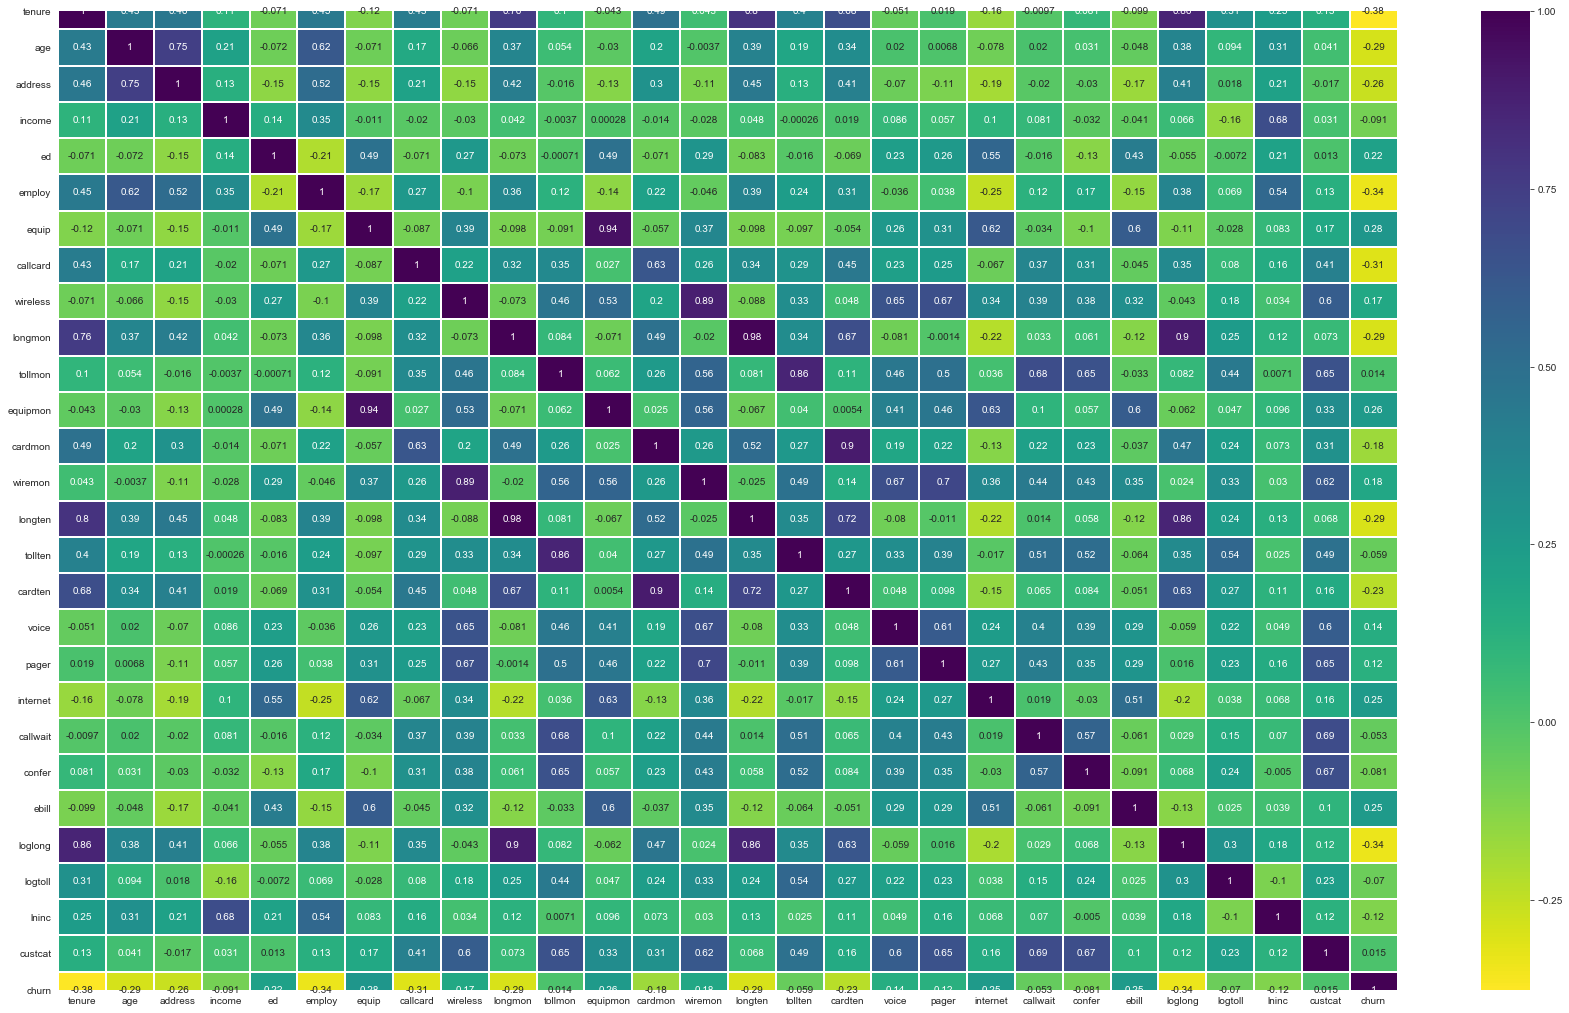

In [9]:
plt.figure(figsize=(30, 18))
sns.heatmap(df.corr(), cmap='viridis_r', annot=True, linewidth=1)

In [10]:
df.columns

Index(['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',
       'callcard', 'wireless', 'longmon', 'tollmon', 'equipmon', 'cardmon',
       'wiremon', 'longten', 'tollten', 'cardten', 'voice', 'pager',
       'internet', 'callwait', 'confer', 'ebill', 'loglong', 'logtoll',
       'lninc', 'custcat', 'churn'],
      dtype='object')

In [12]:
x = df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']].values
x[0:5]

array([[ 11.,  33.,   7., 136.,   5.,   5.,   0.],
       [ 33.,  33.,  12.,  33.,   2.,   0.,   0.],
       [ 23.,  30.,   9.,  30.,   1.,   2.,   0.],
       [ 38.,  35.,   5.,  76.,   2.,  10.,   1.],
       [  7.,  35.,  14.,  80.,   2.,  15.,   0.]])

In [13]:
y = df['churn'].values
y[0:5]

array([1., 1., 0., 0., 0.])

In [14]:
x = preprocessing.StandardScaler().fit(x).transform(x)
x[0:5]

array([[-1.13518441, -0.62595491, -0.4588971 ,  0.4751423 ,  1.6961288 ,
        -0.58477841, -0.85972695],
       [-0.11604313, -0.62595491,  0.03454064, -0.32886061, -0.6433592 ,
        -1.14437497, -0.85972695],
       [-0.57928917, -0.85594447, -0.261522  , -0.35227817, -1.42318853,
        -0.92053635, -0.85972695],
       [ 0.11557989, -0.47262854, -0.65627219,  0.00679109, -0.6433592 ,
        -0.02518185,  1.16316   ],
       [-1.32048283, -0.47262854,  0.23191574,  0.03801451, -0.6433592 ,
         0.53441472, -0.85972695]])

## Splitting Data

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=4, test_size= 0.2)
print("Train Set: ", X_train.shape, y_train.shape)
print("Test Set: ", X_test.shape, y_test.shape)

Train Set:  (160, 7) (160,)
Test Set:  (40, 7) (40,)


# Modeling

## Model-1: Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [18]:
lr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)
lr

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
yhat1 = lr.predict(X_test)
yhat1

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0.])

## Model-2 : XGboost

In [41]:
from xgboost import XGBClassifier

In [42]:
clas = XGBClassifier()

In [43]:
clas

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [52]:
clas.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [53]:
yhat2 = clas.predict(X_test)
yhat2

array([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0.])

# Evaluation

## Jaccard index

In [55]:
from sklearn.metrics import jaccard_similarity_score
print("Accuracy of Model 1: ", jaccard_similarity_score(y_test, yhat1))   
print("Accuracy of Model 2: ", jaccard_similarity_score(y_test, yhat2)) 

Accuracy of Model 1:  0.75
Accuracy of Model 2:  0.675


/Users/finneysunny/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
/Users/finneysunny/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


# Result

As per the accuracy score we will use model 1 i.e., logistic regression model.